# Interpretability in Deep Learning
Interpretability, part of the broader topic of explainable AI (XAI), is the process of adding explanations to deep learning model predictions. These explanations should help us understand why particular predictions are made. This is a critical topic because being able to understand model predictions is justified from a practical, theoretical, and increasingly a regulatory stand-point. It is practical because it has been shown that people are more likely to use predictions of a model if they can understand the rationale {cite}`lee2004trust`. Another practical concern is that correctly implementing methods is much easier when one can understand how a model arrived at a prediction. A theoretical justification for transparency is that it can help identify incompleteness in model domains (i.e., covariate shift){cite}`doshi2017towards`. It is now becoming a compliance problem because both the European Union {cite}`goodman2017european` and the G20 {cite}`Development2019` have recently adopted guidelines that recommend or require explanations for machine predictions. The European Union is considering going further with more [strict draft legislation](https://digital-strategy.ec.europa.eu/en/library/proposal-regulation-laying-down-harmonised-rules-artificial-intelligence-artificial-intelligence) being considered. 

A famous example on the need for explainable AI is found in Caruana et al.{cite}`caruana2015intelligible` who built an ML predictor to assess mortality risk of patients in the ER with pneumonia. The idea is that patients with pneumonia are screened with this tool and it helps doctors know which patients are more at risk of dying. It was found to be quite accurate. When the interpretation of its predictions were examined though, the reasoning was medically insane. The model surprisingly suggested patients with asthma (called asthmatics) have a reduced mortality risk when coming to the ER with pneumonia. Asthma, a condition which makes it difficult to breathe, was found to *make pneumonia patients less likely to die.* This was incidental; asthmatics are actually more at risk of dying from pneumonia but doctors are acutely aware of this and are thus more aggressive and attentive with them. Thanks to the increase care and attention from doctors, there are fewer mortalities. From an empirical standpoint, the model predictions are correct. However if the model were put into practice, it could have cost lives by incorrectly characterizing asthmatics as low mortality risk. Luckily the interpretability of their model helped researchers identify this problem. Thus, we can see that interpretation should always be a step in the construction of predictive models. 

## What is an explanation?

We'll use the definition of explanation from Miller {cite}`miller2019explanation`. Miller distinguishes between interpretability, justification, and explanation with the following definitions:

* **interptability** "the degree to which an observer can understand the cause of a decision". Miller considers this synonymous with explainability.
* **justification** evidence or explanation of why a decision is good, like testing error or accuracy of a model
* **explanation** explanations are a presentation of information intended for humans that give the context and cause for an outcome. These are the major focus of this chapter.

We will dig deeper into what constitutes an *explanation*, but note an explanation is different than justifying a prediction. Justification is what we've focused on previously: empirical evidence for why we should believe model predictions are accurate. An explanation provides a *cause* for the prediction. Ultimately, explanations are intended to be understood by humans.

Deep learning alone is a black box modeling technique it not interpretable or explainable. Examining the weights or model equation provides little insight into why predictions are made. Thus, interpretability is an extra task and means adding an explanation to predictions from the model. This is a challenge because of both the black box nature of deep learning and because there is no consensus on what exactly constitutes an "explanation" for model predictions {cite}`doshi2017towards`. For some, interpretability means having a natural language explanation justifying each prediction. For others, it can be simply showing which features contributed most to the prediction. 

There are two broad approaches to interpretation of ML models: post hoc interpretation via explanations and self-explaining models {cite}`Murdoch2019`. Self-explaining models are constructed so that an expert can view output of the model and connect it with the features through reasoning. They inherently interpretable. Self-explaining models are highly dependent on the task model{cite}`montavon2018methods`. A familiar example would be a physics based simulation like molecular dynamics or a single-point quantum energy calculation. You can examine the molecular dynamics trajectory, look at output numbers, and an expert can explain why, for example, the simulation predicts a drug molecule will bind to a protein. It may seem like this would be useless for deep learning interpretation. However, we will see later that we can create a **proxy model** (sometimes **surrogate model**) that is self-explaining and train it to agree with the deep learning model. Why will this training burden be any less than just using the proxy model from the beginning? We can generate an infinite amount of training data because our trained neural network can label arbitrary points. You can also construct deep learning models which have self-explaining features in them, like attention {cite}`bahdanau2014neural`. This allows you to connect the input features to the prediction based on attention. 

Post hoc interpretation by creating explanations can be approached in a number of ways, but the most common are training data importance, feature importance, and counterfactual explanations{cite}`wellawatte_seshadri_white_2021,ribeiro2016should,ribeiro2016model,wachter2017counterfactual`. An example of a post hoc interpretation based on data importance is identifying the most influential training data to explain a prediction {cite}`koh2017understanding`. It is perhaps arguable if this gives an *explanation*, but it certainly helps understand which data is relevant for a prediction. Feature importance is probably the most common XAI approach and frequently appear in computer vision research where the pixels most important for the class of an image are highlighted. Finally, counterfactual explanations are an emerging approach where a new data point is generated (in same distribution as training data features) that serves as a counterfactual. A counterfactual gives insight into how important and sensitive the features are. An example might be in a model that recommends giving a loan. A model could produce the following counterfactual explanation (from {cite}`wachter2017counterfactual`):

> You were denied a loan based on your annual income, zip code, and assets. If 
> your annual income had been $45,000, you would have been offered a loan.

The second sentence is the conuterfactual and shows how the features could be changed to affect the model outcome. Coutnerfactuals provide a nice balance of complexity and explanatory power.

This was a brief overview of large field of XAI. You can find a recent review of interpretable deep learning in Samek et al. {cite}`9369420` and Christopher Molnar has a [broad online book](https://christophm.github.io/interpretable-ml-book/) about interpretable machine learning, including deep learning {cite}`molnar2019`. Prediction error and confidence in predictions is not covered here, since they are more about justification, but see the methods from {doc}`../ml/regression` which apply. 

## Feature Importance

Feature importance is the most straightforward and common method of interpreting a machine learning model. The output of feature importance is a ranking or numerical values for each feature, typically for a single prediction. If you are trying to understand the feature importance across the whole model, this is called **global** feature importance and **local** for a single prediction. Global feature importance and global interpretability is relatively rare because the best models change which features are important in different regions of feature space.

Let's start with a linear model to see feature importance:

\begin{equation}
\hat{y} = \vec{w}\vec{x} + b 
\end{equation}

where $\vec{x}$ is our feature vector. A simple way to assess feature importance is to simply look at the weight value $w_i$ for a particular feature $x_i$. The weight $w_i$ shows how much $\hat{y}$ would change if $x_i$ is increased by 1 while all other features are constant. If the magnitude of our features are comparable, then this would be a reasonable way to rank features. However, if our features have units, this approach is sensitive to unit choices and relative magnitude of features. For example if our temperature was changed from Celsius to Fahrenheit, a 1 degree increase will have a smaller effect. 

To remove the effect of feature magnitude and units, a slightly better way to assess feature importance is to divide $w_i$ by the **standard error**  in the feature values. Recall that standard error is just the ratio of sum of squared error in predicted value divided by the total deviation in the feature. Standard error is a ratio of prediction accuracy to feature variance -- and the prediction accuracy is independent of the feature and thus has no effect for ranking feature importance. $w_i$ divided by standard error is called the $t$-statistic because it can be compared with the $t$-distribution for assessing feature importance.

\begin{equation}
t_i = \frac{w_i}{S_{w_i}},\; S^2_{w_i} = \frac{1}{N - D}\sum_j \frac{\left(\hat{y}_j - y_j\right)^2}{\left(x_{ij} - \bar{x}_i\right)^2}
\end{equation}

where $N$ is the number of examples,  $D$ is the number of features, and $\bar{x}_i$ is the average value of the $i$th feature. The $t_i$ value can be used to rank features and it can be used for a hypothesis test: if $P(t > t_i) < 0.05$ then that feature is significant, where $P(t)$ is Student's $t$-distribution. Note that a feature's significance is sensitive to which features are present in a model; if you add new features some may become redundant.

If we move to a non-linear learned function $\hat{f}(\vec{x})$, we must compute how the prediction changes if a feature value increases by 1 via the derivative approximation:

$$
\frac{\Delta \hat{f}(\vec{x})}{\Delta x_i} \approx \frac{\partial  \hat{f}(\vec{x})}{\partial x_i}
$$

so a change by 1 is

\begin{equation}
\Delta \hat{f}(\vec{x}) \approx \frac{\partial  \hat{f}(\vec{x})}{\partial x_i}.
\end{equation}


In practice, we make a slight variation on this equation -- instead of a Taylor series centered at 0 approximating this change, we center at some other root (point where the function is 0). This "grounds" the series at the decision boundary (a root) and then you can view the partials as "pushing" the predicted class away or towards the decision boundary. Another way to think about this is that we use the first-order terms of the Taylor series to build a linear model. Then we just apply what we did above to that linear model and use the coefficients as the "importance" of features. Specifically, we use this surrogate function for $\hat{f}(\vec{x})$:

\begin{equation}
\require{cancel}
\hat{f}(\vec{x}) \approx \cancelto{0}{f(\vec{x}')} +  \nabla\hat{f}(\vec{x}')\cdot\left(\vec{x} - \vec{x}'\right)
\end{equation}

where $\vec{x}'$ is the root of $\hat{f}(\vec{x})$. In practice people may choose the trivial root $\vec{x}' = \vec{0}$, however a nearby root is ideal. This root is often called the **baseline** input. Note that as opposed to the linear example above, we consider the product of the partial $\frac{\partial  \hat{f}(\vec{x})}{\partial x_i}$ and the increase above baseline $(x_i - x_i')$.

### Neural Network Feature Importance

In neural networks the partial derivatives are a poor approximation of the real changes to the output. Small changes to the input can have discontinuous changes, making the terms above have little explanatory power. This is called the **shattered gradients** problem {cite}`pmlr-v70-balduzzi17b`. Breaking down each feature separately also misses correlations between features -- which don't exist in a linear model. Thus the derivative approximation works satisfactorily in locally linear models, but not deep neural networks.

There are a variety of techniques that get around the issue of shattered gradients in neural networks. Two popular methods are integrated gradients {cite}`sundararajan2017axiomatic` and SmoothGrad{cite}`smilkov2017smoothgrad`. Integrated gradients creates a path from $\vec{x}'$ to $\vec{x}$ and integrates Equation 4 along that path:

\begin{equation}
\textrm{IG}_i = \left(\vec{x} - \vec{x}'\right) \int_0^1\left[\nabla\hat{f}\left(\vec{x}' + t\left(\vec{x} - \vec{x}'\right)\right)\right]_i\,dt
\end{equation}

where $t$ is some increment along the path such that $\vec{x}' + t\left(\vec{x} - \vec{x}'\right) = \vec{x}'$ when $t = 0$ and $\vec{x}' + t\left(\vec{x} - \vec{x}'\right) = \vec{x}$ when $t = 1$. This gives us the integrated gradient for each feature $i$. The integrated gradients are the importance of each feature, but without the complexity of shattered gradients. There are some nice properties too, like $\sum_i \textrm{IG}_i = f(\vec{x}) - f(\vec{x}')$ so that the integrated gradients provide a complete partition of the change from the baseline to the prediction{cite}`sundararajan2017axiomatic`.

Implementing integrated gradients is actually relatively simple. You approximate the path integral with a Riemann sum by breaking the path into a set of discrete inputs between the input features $\vec{x}$ and the baseline $\vec{x}'$. You compute the gradient of these inputs with the neural network. Then you multiply that be the change in features above baseline: $\left(\vec{x} - \vec{x}'\right)$.

SmoothGrad is a similar idea to the integrated gradients. Rather than summing up the gradients along a path though, we sum gradients from random points nearby our prediction. The equation is:

\begin{equation}
\textrm{SG}_i = \sum_j^M\left[\nabla\hat{f}\left(\vec{x}' + \vec{\epsilon}\right)\right]_i
\end{equation}

where $M$ is a choice of sample number and $\vec{\epsilon}$ is sampled from $D$ zero-mean Guassians {cite}`smilkov2017smoothgrad`. The only change in implementation here is to replace the path with a series of random perturbations.

Beyond these gradient based approaches, Layer-wise Relevance Propagation (LRP) is another popular approach for feature importance analysis in neural networks. LRP works by doing a backwards propogation through the neural network that partitions the output value of one layer to the input features. It "distributes relevance". What is unusual about LRP is that each layer type needs its own implementation. It doesn't rely on the analytic derivative, but instead a Taylor series expansion of the layer equation. There are variants for GNNs and NLP, so that LRP can be used in most settings in materials and chemistry {cite}`Montavon2019`.

### Shapley Values

A model agnostic way to treat feature importance is with **Shapley values.** Shapley values come from game theory and are a solution to how to pay a coalition of cooperating players according to their contributions. Imagine each feature is a player and we would like to "pay" them according to their contribution to the predicted value. A Shapley value $\phi_i$ is the pay to feature $i$. We break-up the predicted function value $\hat{f}(x)$ into the Shapley values so that the sum of the pay is the function value ($\sum_i \phi_i = \hat{f}(x)$. This means you can interpet the Shapley value of a feature as its numerical contribution to the prediction. Shapley values are powerful because their calculation is agnostic to the model, they partition the predicted value among each feature, and they have other attributes that we would desire in an explanation of a prediction (symmetry, linearity, permutation invariant, etc.). Their disadvantage are that exact computation is combinatorial with respect to feature number and they have no sparsity, making them less helpful as feature number grows. Most methods we discuss here also have no sparsity -- you can also force your model to be sparse to achieve sparse explanations.

Shapley values are computed as

\begin{equation}
\phi_i = \frac{1}{Z}\sum_{S \in M \backslash x_i}v(S\cup x_i) - v(S)
\end{equation}
$$
Z = \frac{|S|!\left(N - |S| - 1\right)!}{N!}
$$

where $S \in N \backslash x_i$ means all sets of features that exclude feature $x_i$, $S\cup x_i$ means putting back feature $x_i$ into the set, and $v(S)$ is the value of $\hat{f}(x)$ using only the features included in $S$, and $Z$ is a normalization value. The formula can be interpreted as the mean of all possible differences in $\hat{f}$ formed by adding/removing feature $i$. 

One immediate concern though is how can we "remove" feature $i$ from a model equation? We marginilize out feature $i$. Recall a marginal is a way to integrate out a random variable -- $P(x) = \int\, P(x,y)\,dy$. That integrates over all possible $x$ values. Marginalization can be used on functions of random variables, which obviously are also random variables, by taking an expectation: $E_y[f | X = x] = \int\,f(X=x,y)P(X=x,y)\, dy$. I've emphasized that the random variable $X$ is fixed in the integral and thus $E_y[f]$ is a function of $x$. $y$ is removed by computing the expected value of $f(x,y)$ where $x$ is fixed (the function argument). We're essentially replacing $f(x,y)$ with a new function $E_y[f]$ that is the average of all possible $y$ values I'm over-explaining this though, it's quite intuitive. The other detail is that *value* is the change relative to the average of $\hat{f}$. You can typically ignore this extra term - it cancels, but I include it for completeness. Thus the value equation becomes {cite}`vstrumbelj2014explaining`:

\begin{equation}
v(x_i) = \int\,f(x_0, x_1, \ldots, x_i,\ldots, x_N)P(x_0, x_1, \ldots, x_i,\ldots, x_N)\, dx_i - E\left[\hat{f}(\vec{x})\right]
\end{equation}

How do we compute the marginal $\int\,f(x_0, x_1, \ldots, x_i,\ldots, x_N)P(x_0, x_1, \ldots, x_i,\ldots, x_N)\, dx_i$? We do not have a known probability distribution $P(\vec{x})$. We can sample from $P(\vec{x})$ by considering our data as an **empirical distribution**. That is, we can sample from $P(\vec{x})$ by sampling data points. There is a little bit of complexity here because we need to sample the $\vec{x}$'s jointly, we cannot just mix together individual features randomly because there are correlations between features that will be removed. {cite}`vstrumbelj2014explaining` showed that we can directly estimate the $i$th Shapley value with:

\begin{equation}
\phi_i(\vec{x}) = \frac{1}{M}\sum^M \hat{f}\left(\vec{z}_{+i}\right) - \hat{f}\left(\vec{z}_{-i}\right)
\end{equation}

where $\vec{z}$ is a "chimera" exapmle constructed from the real example $\vec{x}$ and a randomly drawn example $\vec{x}'$. We randomly select from $\vec{x}$ and $\vec{x}'$ to construct $\vec{z}$, except $\vec{z}_{+i}$ specifically has the $i$th feature from the example $\vec{x}$ and $\vec{z}_{-i}$ has the $i$th feature from the random example $\vec{x}'$. $M$ is chosen large enough to get a good sample for this value. {cite}`vstrumbelj2014explaining` gives guidance on choosing $M$, but basically as large $M$ as computationally feasible reasonable. 

```{margin}
Marginalizing features *is not* the same as replacing features with their average.
```
With this efficient approximation method, the strong theory, and independence of model choice, Shapley values are an excellent choice for describing feature importance for examples.

## Running This Notebook


Click the &nbsp;<i aria-label="Launch interactive content" class="fas fa-rocket"></i>&nbsp; above to launch this page as an interactive Google Colab. See details below on installing packages, either on your own environment or on Google Colab

````{tip} My title
:class: dropdown
To install packages, execute this code in a new cell

```
!pip install matplotlib numpy pandas seaborn jax jaxlib dm-haiku
```

````

In [1]:
import haiku as hk
import jax
import tensorflow as tf
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import warnings
import urllib
import jax.experimental.optimizers as opt
warnings.filterwarnings('ignore')
sns.set_context('notebook')
sns.set_style('dark',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#666666', 'ytick.color': '#666666',
                        'axes.edgecolor': '#666666', 'axes.linewidth':     0.8 , 'figure.dpi': 300})
color_cycle = ['#1BBC9B', '#F06060', '#5C4B51', '#F3B562', '#6e5687']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_cycle) 
np.random.seed(0)
tf.random.set_seed(0)

ALPHABET = ['-', 'A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']
def seq2array(seq, L=200):
    return np.pad(list(map(ALPHABET.index, seq)), (0,L - len(seq))).reshape(1, -1)
def array2oh(a):
    a = np.squeeze(a)
    o = np.zeros((len(a), 21))
    o[np.arange(len(a)), a] = 1
    return o.astype(np.float32).reshape(1, -1, 21)

urllib.request.urlretrieve(
    'https://github.com/whitead/dmol-book/raw/master/data/hemolytic.npz', 'hemolytic.npz')
with np.load('hemolytic.npz', 'rb') as r:
    pos_data, neg_data = r['positives'], r['negatives']

## Feature Importance Example

Let's see an example of these feature importance methods on a peptide prediction task to predict if a peptide will kill red blood cells (hemolytic). This is similar to the solubility prediction example from {doc}`layers`. The data is from {cite}`barrett2020investigating`.  The model takes in peptides sequences (e.g., `DDFRD`) and predicts the probability that the peptide is hemolytic. The goal of the feature importance method here will be to identify which amino acids matter most for the hemolytic activity. The hidden-cell below loads and processes the data into a dataset.

In [2]:
# create labels and stich it all into one 
# tensor
labels = np.concatenate((np.ones((pos_data.shape[0], 1), dtype=pos_data.dtype), np.zeros((neg_data.shape[0], 1) , dtype=pos_data.dtype)), axis=0)
features = np.concatenate((pos_data, neg_data), axis=0)
# we now need to shuffle before creating TF dataset
# so that our train/test/val splits are random
i = np.arange(len(labels))
np.random.shuffle(i)
labels = labels[i]
features = features[i]
L = pos_data.shape[-2]

# need to add token for empty amino acid
# dataset just has all zeros currently
features = np.concatenate((np.zeros((features.shape[0], L, 1)), features), axis=-1)
features[np.sum(features, -1) == 0, 0] = 1.0

batch_size = 16
full_data = tf.data.Dataset.from_tensor_slices((features.astype(np.float32), labels))

# now split into val, test, train
N = pos_data.shape[0] + neg_data.shape[0]
split = int(0.1 * N)
test_data = full_data.take(split).batch(batch_size)
nontest = full_data.skip(split)
val_data, train_data = nontest.take(split).batch(batch_size), nontest.skip(split).shuffle(1000).batch(batch_size)

We rebuild the convolution model in JAX (using Haiku) to make working with gradients a bit easier. We also make a few changes to the model -- we pass in the sequence length and amino acid fractions as extra information in addition to the convolutions.

In [3]:
def binary_cross_entropy(logits, y):
    '''Binary cross entropy without sigmoid. Works with logits directly'''
    return jnp.clip(logits, 0, None) - logits * y + jnp.log(1 + jnp.exp(-jnp.abs(logits)))
def model_fn(x):
    # get fractions, excluding skip character
    aa_fracs = jnp.mean(x, axis=1)[:,1:]
    # compute convolutions/poolings
    mask = jnp.sum(x[...,1:], axis=-1, keepdims=True)    
    for kernel, pool in zip([5, 3, 3], [4, 2, 2]):
        x = hk.Conv1D(16, kernel)(x) * mask
        x = jax.nn.tanh(x)
        x = hk.MaxPool(pool, pool, 'VALID')(x)
        mask = hk.MaxPool(pool, pool, 'VALID')(mask)
    # combine fractions, length, and convolution ouputs
    x = jnp.concatenate((hk.Flatten()(x), aa_fracs, jnp.sum(mask, axis=1)),axis=1)        
    # dense layers. no bias, so zeros give P=0.5
    logits = hk.Sequential([               
        hk.Linear(256, with_bias=False), jax.nn.tanh,
        hk.Linear(64, with_bias=False), jax.nn.tanh,
        hk.Linear(1, with_bias=False)
    ])(x)
    return logits
model = hk.without_apply_rng(hk.transform(model_fn))
def loss_fn(params, x, y):    
    logits = model.apply(params, x)
    return jnp.mean(binary_cross_entropy(logits, y))
@jax.jit
def hemolytic_prob(params, x):
    logits = model.apply(params, x)
    return jax.nn.sigmoid(jnp.squeeze(logits))
@jax.jit
def accuracy_fn(params, x, y):
    logits = model.apply(params, x)
    return jnp.mean((logits >= 0) * y + (logits < 0) * (1 - y))

In [4]:
rng = jax.random.PRNGKey(0)
xi, yi = features[:batch_size], labels[:batch_size]
params = model.init(rng, xi)

opt_init, opt_update, get_params = opt.adam(1e-2)
opt_state = opt_init(params)

@jax.jit

def update(step, opt_state, x, y):
    value, grads = jax.value_and_grad(loss_fn)(get_params(opt_state), x, y)
    opt_state = opt_update(step, grads, opt_state)
    return value, opt_state

In [5]:
epochs = 32
for e in range(epochs):
    avg_v = 0
    for i, (xi, yi) in enumerate(train_data):
        v, opt_state = update(i, opt_state, xi.numpy(), yi.numpy())        
        avg_v += v
opt_params = get_params(opt_state)

Here we compute the accuracy of our model, which is quite good. 

In [6]:
acc = []
for xi, yi in test_data:
    acc.append(accuracy_fn(opt_params, xi.numpy(), yi.numpy()))
print(jnp.mean(np.array(acc)))

0.95208335


Let's try an amino acid sequence, a peptide, to get a feel for the model. The model outputs logits (logarithm of odds), which we put through a sigmoid to get probabilities. The peptides must be converted from a sequence to a matrix of one-hot column vectors. We'll try two known sequences: Q is known to be common in hemolytic residues and the second sequence is poly-G, which is the simplest amino acid.

In [7]:
s = 'QQQQQ'
sm = array2oh(seq2array(s))
p = hemolytic_prob(opt_params, sm)
print(f'Probability {s} of being hemolytic {p:.2f}')

s = 'GGGGG'
sm = array2oh(seq2array(s))
p = hemolytic_prob(opt_params, sm)
print(f'Probability {s} of being hemolytic {p:.2f}')

Probability QQQQQ of being hemolytic 1.00
Probability GGGGG of being hemolytic 0.00


It looks reasonable -- the model matches our intuition about these two sequences

### Gradients

Now to start examining *why* a particular sequence is hemolytic! We'll begin by computing the gradients with respect to input -- the naieve approach that is susceptible to shattered gradients. Computing this is a component in the process for integrated and smooth gradients, so not wasted effort. We will use a more complex peptide sequence that is known to be hemolytic to get more interesting analysis. 

In [8]:
def plot_grad(g, s, ax=None):
    #g = np.array(g)
    if ax is None:
        plt.figure()
        ax = plt.gca()
    if len(g.shape) == 3:
        h = g[0, np.arange(len(s)), list(map(ALPHABET.index,s))]
    else:
        h = g
    ax.bar(np.arange(len(s)), height=h)
    ax.set_xticks(range(len(s)))
    ax.set_xticklabels(s)

In [9]:
s = 'RAGLQFPVGRLLRRLLRRLLR'
sm = array2oh(seq2array(s))
p = hemolytic_prob(opt_params, sm)
print(f'Probability {s} of being hemolytic {p:.2f}')

Probability RAGLQFPVGRLLRRLLRRLLR of being hemolytic 1.00


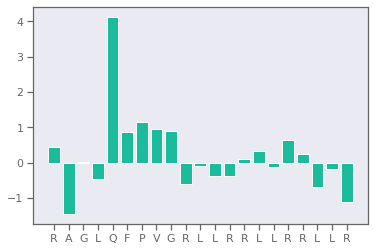

In [10]:
gradient = jax.grad(lambda s: jnp.squeeze(model.apply(opt_params, s)), 0)
g = gradient(sm)
plot_grad(g, s)

Remember that the model outputs logits. Positive value of the gradient mean this amino acid is responsible for pushing hemolytic probability higher and negative values mean the amino acid is pushing towards non-hemolytic. Interestingly, you can see a strong position dependence on the leucine (L) and arginine (R).

### Integrated Gradients

We'll now implement the integrated gradients method. We go through three basic steps:

1. Create an array of inputs going from baseline to input peptide
2. Evaluate gradient on each input
3. Compute the sum of the gradients and multiply it by difference between baseline and peptide

The baseline for us is all zeros -- which gives a probability of 0.5 (logits = 0, a model root). This baseline is exactly on the decision boundary. You could use other baselines like all glycines or all alanines, just they should be at or near probability of 0.5. You can find a detailed and interactive exploration of the baseline choice in {cite}`sturmfels2020visualizing`.

In [11]:
def integrated_gradients(sm, N):
    baseline = jnp.zeros((1, L, 21))
    t = jnp.linspace(0, 1, N).reshape(-1, 1, 1)
    path = baseline * (1 - t) + sm * t
    def get_grad(pi):
        # compute gradient 
        # add/remove batch axes
        return gradient(pi[jnp.newaxis, ...])[0]
    gs = jax.vmap(get_grad)(path)
    # sum pieces (Riemann sum), multiply by (x - x')
    ig = jnp.mean(gs, axis=0, keepdims=True) * (sm - baseline)
    return ig
ig = integrated_gradients(sm, 1024)

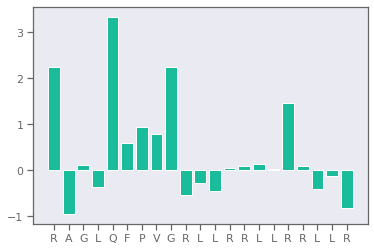

In [12]:
plot_grad(ig, s)

We see that the position dependence has become more pronounced, with arginine being very sensitive to position. Relatively little has qualitatively changed between this and the vanilla gradients.

### SmoothGrad

To do SmoothGrad, our steps are almost identicial:

1. Create an array of inputs that are random pertubations of the input peptide
2. Evaluate gradient on each input
3. Compute the mean of the gradients

There is one additional hyperparameter, $\sigma$, which in principle should be as small as possible while still causing the model output to change.


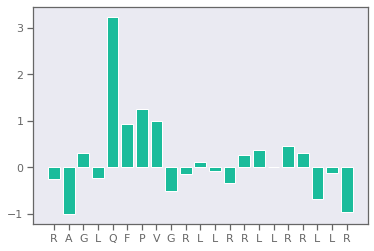

In [13]:
def smooth_gradients(sm, N, rng, sigma=1e-3):
    baseline = jnp.zeros((1, L, 21))
    t = jax.random.normal(rng, shape=(N, sm.shape[1], sm.shape[2])) * sigma
    path = sm + t
    # remove examples that are negative and force summing to 1
    path = jnp.clip(path, 0, 1)
    path /= jnp.sum(path, axis=2, keepdims=True)    
    def get_grad(pi):
        # compute gradient 
        # add/remove batch axes
        return gradient(pi[jnp.newaxis, ...])[0]
    gs = jax.vmap(get_grad)(path)
    # mean
    ig = jnp.mean(gs, axis=0, keepdims=True)
    return ig
sg = smooth_gradients(sm, 1024, jax.random.PRNGKey(0))
plot_grad(sg, s)

It looks remarkably similar to the vanilla gradient setting -- probably because our 1D input/shallow network is not as sensitive to shattered gradients.

### Shapley Value

Now we will approximate the Shapley values for each feature using Equation 10.9. The Shapley value computation is different than previous approaches because it does not require gradients. The basic algorithm is:

1. select random point x'
2. create point z by combining x and x'
3. compute change in predicted function

One efficiency change we make is to prevent modifying the sequence in its padding -- basically preventing exploring making the sequence longer. 

In [14]:
def shapley(i, sm, sampled_x, rng, model, opt_params=opt_params):
    M,F,*_ = sampled_x.shape
    z_choice = jax.random.bernoulli(rng, shape=(M,F))
    # only swap out features within length of sm
    mask = jnp.sum(sm[...,1:], -1)        
    z_choice *= mask
    z_choice = 1 - z_choice
    # construct with and w/o ith feature
    z_choice = jax.ops.index_update(z_choice, jax.ops.index[:,i], 0.)
    z_choice_i = jax.ops.index_update(z_choice, jax.ops.index[:,i], 1.0)
    # select them via multiplication
    z = sm * z_choice[...,jnp.newaxis] + \
        sampled_x * (1 - z_choice[...,jnp.newaxis])
    z_i = sm * z_choice_i[...,jnp.newaxis] + \
        sampled_x * (1 - z_choice_i[...,jnp.newaxis])
    v = model(opt_params, z_i) - model(opt_params, z)    
    return jnp.squeeze(jnp.mean(v, axis=0))
    
# assume data is alrady shuffled, so just take M
M = 4096
sl = len(s)
sampled_x = train_data.unbatch().batch(M).as_numpy_iterator().next()[0]
# make batched shapley so we can compute for all features
bshapley = jax.vmap(shapley, in_axes=(0, None, None, 0, None))
sv = bshapley(jnp.arange(sl), sm, sampled_x, jax.random.split(jax.random.PRNGKey(0), sl), model.apply)

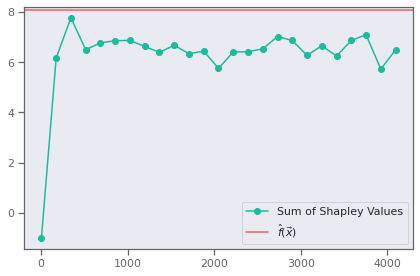

In [15]:
from myst_nb import glue
val = []
ms = np.linspace(2, 4096, 25)
for m in ms.astype(np.int32):
    sampled_x = train_data.unbatch().batch(m).as_numpy_iterator().next()[0]
    val.append(jnp.sum(bshapley(jnp.arange(sl), sm, sampled_x, jax.random.split(jax.random.PRNGKey(0), sl), model.apply)))
plt.plot(ms, val, '-o', label='Sum of Shapley Values')
plt.axhline(model.apply(opt_params, sm), color='C1', label=r'$\hat{f}\left(\vec{x}\right)$')
plt.legend()
plt.tight_layout()
glue('shapley_convg', plt.gcf(), display=False)



One nice check on Shapley values is that we can check that their sum is equal to the value of model function. This should be true because the Shapley values partition the model among the features. That value is computed as:


In [16]:
print(np.sum(sv), model.apply(opt_params, sm))

6.7732835 [[8.085391]]


which is *some* disagreement. This is an effect of the approximation method we're using. We can check that by examining how sample number effects the sum of Shapley values.

```{glue:figure} shapley_convg
---
name: shapley_convg
---
A comparison of sum of Shapley values and function value as a function of samples number in the Shapley value approximation.
```

It is slowly converging. Finally we can view the individual Shapley values, which is our explanation.

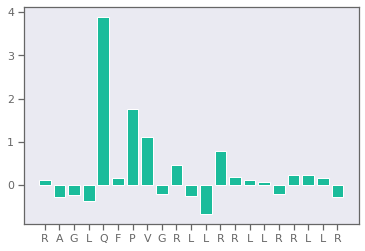

In [17]:
plot_grad(sv, s)

The four methods are shown side-by-side below. 

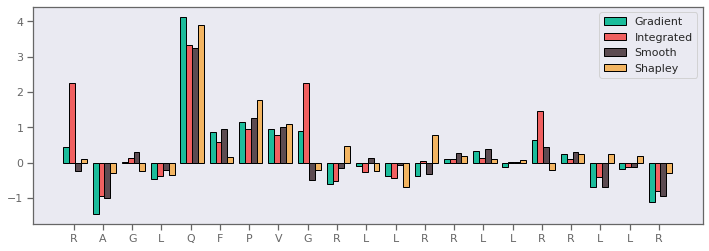

In [18]:
heights = []
plt.figure(figsize=(12,4))
x = np.arange(len(s))
for i,(gi,l) in enumerate(zip([g, ig, sg], ['Gradient', 'Integrated', 'Smooth'])):
    h = gi[0, np.arange(len(s)), list(map(ALPHABET.index,s))]
    plt.bar(x + i/5 - 1/4, h, width=1/5, edgecolor='black', label=l)
plt.bar(x + 3
        /5 - 1/4, sv, width=1/5, edgecolor='black', label='Shapley')
plt.gca().set_xticks(range(len(s)))
plt.gca().set_xticklabels(s)
plt.legend()
plt.show()

As someone who works with peptides, I believe the Shapley is the most accurate here. I wouldn't expect the pattern of L and R to be that significant, which is what the Shapley values show. Another difference is that the Shapley values do not show the phenylalanine (F) as have a significant effect. 

What can we conclude from this information? We could perhaps add an explanation like this: "The sequence is predicted to be hemolytic primarily because of the glutamine, proline, and arrangement of lecucine and arginine."

## Training Data Importance

Another kind of explanation or interpretation we might desire is *which* training data points contribute most to a prediction. This is a more literal answer to the question: "Why did my model predict this?" -- neural networks are a result of training data and thus the answer to why a prediction is made can be traced to training data. Ranking training data for a given prediction helps us understand which training examples are causing the neural network to predict a value. This is like an influence function, $\mathcal{I}(x_i, x)$, which gives a score of incluence for training point $i$ and input $x$. The most straightforward way to compute the influence would be to train the neural network with (i.e., $\hat{f}(x)$) and without $x_i$ (i.e., $\hat{f}_{-x_i}(x)$) and define the influence as

\begin{equation}
\mathcal{I}(x_i, x) = \hat{f}_{-x_i}(x) - \hat{f}(x)
\end{equation}

For example, if a prediction is higher after removing the training point $x_i$ from training, we would say that point has a positive influence. Computing this influence function requires training the model as many times as you have points -- typically computationally infeasible. {cite}`koh2017understanding` show a way to approximate this by looking at infinitesimal changes to the *weights* of each training point. Computing these influence functions do require computing a Hessian with respect to the loss function and thus are not commonly used. If you're using JAX though, this is simple to do.

```{margin}
If using a kernel model, the features are the training data. The above methods like integrated gradients, give training data importance.
```

Training data importance provides an interpretation that is useful for deep learning experts. It tells you which training examples are most influential for a given predictions. This can help troubleshoot issues with data or tracing explanations for spurious predictions. However, a typical user of predictions from a deep learning model will probably be unsatisfied with a ranking of training data as an explanation. 

## Surrogate Models

One of the more general ideas in interpretability is to fit an interpretable model to a black box model *in the neighborhood of a specific example*. We assume that an interpretable model cannot be fit globally to a black box model -- otherwise we could just use the interpretable model and throw away the black box model. However, if we fit the interpretable model to just a small region around an example of interest, we can provide an explanation through the locally correct interpretable model. We call the interpretable model a **local surrogate model**. Examples of local surrogate models that are inherently interpretable include decision trees, linear models, sparse linear models (for succint explanations), a Naive Bayes Classifier, etc.

A popular algorithm for this process of fitting a local surrogate model is called Local Interpretable Model-Agnostic Explanations (LIME) {cite}`ribeiro2016should`. LIME fits the local surrogate model in the neighborhood of the example of interest utilizing the loss function that trained the original black box model. The loss function for the local surrogate model is weighted so that we value points closer to the example of interest as we regress the surrogate model. The LIME paper includes sparsifying the surrogate model in its notation, but we'll omit that from the loss equation since that is more of an attribute of the local surrogate model. Thus, our definition for the local surrogate model loss is

\begin{equation}
\mathcal{l^s}\left(x'\right) = w(x', x)\mathcal{l}\left(\hat{f}_s(x'), \hat{f}(x')\right)
\end{equation}

where $w(x', x)$ is a weight kernel function that weights points near example of interest $x$, $\mathcal{l}(\cdot,\cdot)$ is the original black box model loss, $\hat{f}(\cdot)$ is the black box model, and $\hat{f}_s(\cdot)$ is the local surrogate model.


```{margin}
LIME as formulated in {cite}`ribeiro2016should` gives feature importance descriptions, but you can use Hmm, not sure if I'
```

The weight function is a bit ad hoc -- it depends on the data type. For regression tasks with scalar labels, we use a kernel function and you have a variety of choices: Gaussian, cosine, Epanechnikov. For text, the LIME implementations use a [Hamming distance](https://en.wikipedia.org/wiki/Hamming_distance) which just counts number of text tokens which do not match between two strings. Images use the same distance but with superpixels being the same as the example or blank.

How are the points $x'$ generated? In the continuous case $x'$ is sampled *uniformly*, which is quite a feat since feature spaces are often unbounded. You could sample $x'$ according to your weight function and then omit the weighting (since it was sampled according to that) to avoid issues like unbounded feature spaces. In general, LIME is a bit subjective in continuous vector feature spaces. For images and text, $x'$ is formed by masking tokens (words) and zeroing (making black) superpixels. This leads to explanations that should feel quite similar to Shapley values -- and indeed you can show LIME is equivalent to Shapley values with some small notation changes.

## Counterfactuals 

A counterfactual is a solution to an optimization problem: find an example $x'$ that has a different label than $x$ and as close as possible to $x${cite}`wachter2017counterfactual`. You can formulate this like:

\begin{equation}
\textrm{minimize}\qquad d(x, x')\\
\textrm{such that}\qquad \hat{f}(x) \neq \hat{f}(x')
\end{equation}

In regression settings where $\hat{f}(x)$ outputs a scalar, you need to modify your constraint to be some $\Delta$ away from $\hat{f}(x)$. $x'$ that satisfies this optimization problem is the counterfactual: a condition that did not occur and would have led to a different outcome. Typically finding $x'$ is treated as a derivative-free optimization. You can calculate $\frac{\partial \hat{f}}{\partial x'}$ and do constrained optimization, but in practice it can be faster to just randomly perturb $x$ until $\hat{f}(x) \neq \hat{f}(x')$ like a Monte Carlo optimization. You can also use a generative model that can propose new $x'$ via unsupervised training. See {cite}`wellawatte_seshadri_white_2021` for a universal counterfactual generator for molecules. See {cite}`numeroso2020explaining` for a method specifically for graph neural networks of molecules. 

Defining distance is an important subjective concern, that we saw above for LIME. A common example for molecular structures is Tanimoto similarity (also known as Jaccard index).

Counterfactuals have a disadvantage compared to Shapley values: they do not provide a *complete* explanation. Shapley values sum to the prediction, meaning we are not missing any part of the explanation. Counterfactuals modify as few features as possible (minimizing distance) and so may omit information about features that still contribute to a prediction.

### Example

We can quickly implement this idea for our peptide example above. We can define our distance as the Hamming distance. Then the closes $x'$ would be a single amino acid substitution. Let's just try enumerating those and see if we can achieve a label swap. We'll define a function that does a single substitution:

In [19]:
def check_cf(x, i, j):    
    # copy
    x = jnp.array(x)        
    # substitute
    x = jax.ops.index_update(x, jax.ops.index[:,i], 0)
    x = jax.ops.index_update(x, jax.ops.index[:,i,j], 1)
    #print(x)
    return model.apply(opt_params, x)
check_cf(sm, 0,0)

DeviceArray([[8.558988]], dtype=float32)

Then build all possible substitutions with {obj}`jnp.meshgrid<jax.numpy.meshgrid>` and apply our function over that with {obj}`vmap<jax.vamp>`. {obj}`.ravel()<jax.numpy.ravel>` makes our array of indices be a single dimensions, so we do not need to worry about doing a complex vmap. 

In [20]:
ii, jj = jnp.meshgrid(jnp.arange(sl), jnp.arange(21))
ii, jj = ii.ravel(), jj.ravel()
x = jax.vmap(check_cf, in_axes=(None, 0, 0))(sm, ii, jj)

Now we'll display all the single amino acid substitutions which resulted in a negative prediction - the logits are less than zero.

In [40]:
from IPython.core.display import display, HTML

out = ['<tt>']
for i, j in zip(ii[jnp.squeeze(x) < 0],
                jj[jnp.squeeze(x) < 0]):    
    out.append(f'{s[:i]}<span style="color:red;">{ALPHABET[j]}</span>{s[i+1:]}<br/>')
out.append('</tt>')
display(HTML(''.join(out)))

We have a few to choose from, but the interpretation is essentially exchange the glutamine with a hydrophobic group or replace the proline with V, F, A, or C to make the peptide non-hemolytic. Stated as a counterfactual: "If the glutamine were exchanged with a hydrophobic amino acid, the peptide would not be hemolytic".

## Specific Architectures Explanations

The same principles above apply to GNNs, but there are competing ideas about how best to translate these ideas to work on graphs. See {cite}`agarwal2021towards` for a discussion of theory of interpretability specifically for GNNs and {cite}`yuan2020explainability` for a survey of the methods available for constructing explanations in GNNs. 

NLP is another area where there are specific approaches to constructing explanations and interpretation. See {cite}`madsen2021post` for a recent survey.

## Summary

* Interpretation of deep learning models is imperitive for ensuring model correctness, making predictions useful to humans, and can be required for legal compliance.
* Interpretability of neural networks is part of a broader topic of explainability in AI (XAI), a topic that is in its infancy
* An *explanation* is still ill-defined, but most often is expressed in terms of model features.
* Strategies for explanations inlcude feature importance, training data importance, counterfactuals, and surrogate models that are locally accurate,
* Most explanations are generated per-example (at inference).
* The most systemtic but expensive to compute explanations are Shapley values.
* Some argue that counterfactuals provide the most intuitive and satisfying explanations, but they may not be complete explanations. 

## Cited References

```{bibliography}
:style: unsrtalpha
:filter: docname in docnames
```